# Surfs Up!
## University of Denver Data Analytics Bootcamp
### Matthew Stewart - April 28, 2019
---

### Purpose and Observations
The purpose of this project is to analyze data around Honolulu, Hawaii in regards to climate and weather observation stations.

Observations:
* Precipitation generally seems relatively constant, with several spikes throughout the year.
* The most frequently-observed temperatures were around 75 degrees Fahrenheit.

### Initial Setup
In this section, we will accomplish the following:
* Inspect our sqlite database file to find our table names and column names
* Reflect these tables into python classes
* Query these classes and build dataframes with the results
* Clean the data

In [1]:
# Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import style
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Create engine
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

In [4]:
# Create inspector variable
inspector = inspect(engine)

In [5]:
# Display table names
inspector.get_table_names()

['measurement', 'station']

In [6]:
# Display column names for first table
columns_measurement = inspector.get_columns('measurement')
for column in columns_measurement:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Display column names for second table
columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Reflect the database tables
Base = automap_base()
Base.prepare(engine, reflect = True)
Base.classes.keys()

['measurement', 'station']

In [9]:
# Assign the new classes to variables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create a session
session = Session(engine)

In [11]:
# Query the first class and convert results to dataframe
measurement_table = (session
                    .query(Measurement.id, Measurement.station, Measurement.date,
                           Measurement.prcp, Measurement.tobs)
                    .all())
measurement_df = pd.DataFrame(measurement_table)
measurement_df.set_index('id', inplace=True)
measurement_df.head(10)

,station,date,prcp,tobs
id,,,,
1,USC00519397,2010-01-01,0.08,65.0
2,USC00519397,2010-01-02,0.00,63.0
3,USC00519397,2010-01-03,0.00,74.0
4,USC00519397,2010-01-04,0.00,76.0
5,USC00519397,2010-01-06,NaN,73.0
6,USC00519397,2010-01-07,0.06,70.0
7,USC00519397,2010-01-08,0.00,64.0
8,USC00519397,2010-01-09,0.00,68.0
9,USC00519397,2010-01-10,0.00,73.0


In [12]:
# Look for incomplete rows
measurement_df.count()

station    19550
date       19550
prcp       18103
tobs       19550
dtype: int64

In [13]:
# Fill NaN values with 0; re-count the rows
measurement_df.fillna(0, inplace = True)
measurement_df.count()

station    19550
date       19550
prcp       19550
tobs       19550
dtype: int64

In [14]:
# Final results for first dataframe
measurement_df.head(10)

,station,date,prcp,tobs
id,,,,
1,USC00519397,2010-01-01,0.08,65.0
2,USC00519397,2010-01-02,0.00,63.0
3,USC00519397,2010-01-03,0.00,74.0
4,USC00519397,2010-01-04,0.00,76.0
5,USC00519397,2010-01-06,0.00,73.0
6,USC00519397,2010-01-07,0.06,70.0
7,USC00519397,2010-01-08,0.00,64.0
8,USC00519397,2010-01-09,0.00,68.0
9,USC00519397,2010-01-10,0.00,73.0


In [15]:
# Query the second class and covert results to dataframe
station_table = (session
                 .query(Station.id, Station.station, Station.name,
                        Station.latitude, Station.longitude, Station.elevation)
                 .all())
station_df = pd.DataFrame(station_table)
station_df.set_index('id', inplace=True)
station_df

,station,name,latitude,longitude,elevation
id,,,,,
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [16]:
# Look for incomplete rows
station_df.count()

station      9
name         9
latitude     9
longitude    9
elevation    9
dtype: int64

---

### Precipitation Analysis

This section illutrates the final year of precipitation data in a line graph.

NOTE:  For future analysis, it might make more sense to group by measurement date and plot the precipitation data as a bar graph.

In [53]:
# Identify the maximum date in the data and calculate the date one year prior in order to obtain our final-year date range.
# Convert min and max dates to strings so that we can query the sqlite database.
max_date_as_string = measurement_df.date.max()
max_date_as_date = dt.datetime.strptime(max_date_as_string, '%Y-%m-%d')
min_date_as_date = max_date_as_date - dt.timedelta(days = 365)
min_date_as_string = str(min_date_as_date.date())

print(max_date_as_string)
print(min_date_as_string)

2017-08-23
2016-08-23


In [65]:
# Query precipitation data in date range identified above.
prcp_table = (session
              .query(Measurement.date, Measurement.prcp)
              .filter(Measurement.date >= min_date_as_string)
              .filter(Measurement.date <= max_date_as_string)
              .order_by(Measurement.date)
              .all())
prcp_df = pd.DataFrame(prcp_table, columns = ['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace = True)
prcp_df.head(20)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


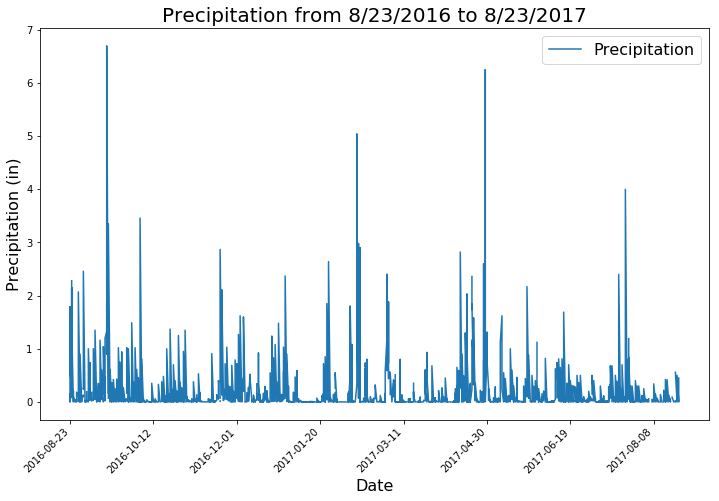

In [47]:
# Plot above dataframe as a line graph
plt.figure(figsize = (12,8))
plt.plot(prcp_df.index, prcp_df.Precipitation)
plt.xticks(rotation = 45, ha = 'right')
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MaxNLocator(10)) # limits number of visible xticks and corresponding labels
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Precipitation (in)', fontsize=16)
ax.set_title('Precipitation from 8/23/2016 to 8/23/2017', fontsize=20)
ax.legend(['Precipitation'], fontsize=16)
plt.subplots_adjust(bottom = 0.2)
plt.savefig('Output/Precipitation_Plot.png')
plt.show()

In [55]:
# Display summary statistics
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


---

### Station Analysis

This section analyzes the station data.  In this section, we identify the:
* number of stations
* number of observations per station
* temperature data for most active station
* frequency of different temperature observations (plotted as a histogram)

In [56]:
# Calculate the number of stations
station_count = (session
                 .query(Station.id)
                 .count())
print(f'The total number of stations is {station_count}.')

The total number of stations is 9.


In [58]:
# Calulate the number of temperature observations per station and sort by most active station
station_observations = (session
                        .query(Measurement.station, func.count(Measurement.tobs))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.tobs).desc())
                        .all())
station_observations_df = pd.DataFrame(station_observations, columns = ['Station', 'Num_of_Observations'])
station_observations_df

,Station,Num_of_Observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [23]:
print(f'The station with the most observations is {station_observations_df.Station[0]}.')

The station with the most observations is USC00519281.


In [59]:
# Calculate min, max, and avg temperature for most active station
active_station_data = (session
                       .query(func.min(Measurement.tobs),
                              func.max(Measurement.tobs), func.avg(Measurement.tobs))
                       .filter(Measurement.station == station_observations_df.Station[0])
                       .all())
print('The min, max, and average temperature for the most active station in degrees Fahrenheit is:')
print(active_station_data)

The min, max, and average temperature for the most active station in degrees Fahrenheit is:
[(54.0, 85.0, 71.66378066378067)]


In [61]:
# Calculate specific temperature observations for most active station during last year of data
tobs_data = (session
             .query(Measurement.date, Measurement.tobs)
             .filter(Measurement.station == station_observations_df.Station[0])
             .filter(Measurement.date >= min_date_as_string)
             .filter(Measurement.date <= max_date_as_string)
             .order_by(Measurement.date)
             .all())
tobs_df = pd.DataFrame(tobs_data, columns = ['Date', 'Temp_Observations'])
tobs_df.head(20)

,Date,Temp_Observations
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
5,2016-08-28,73.0
6,2016-08-29,78.0
7,2016-08-30,77.0
8,2016-08-31,78.0
9,2016-09-01,80.0


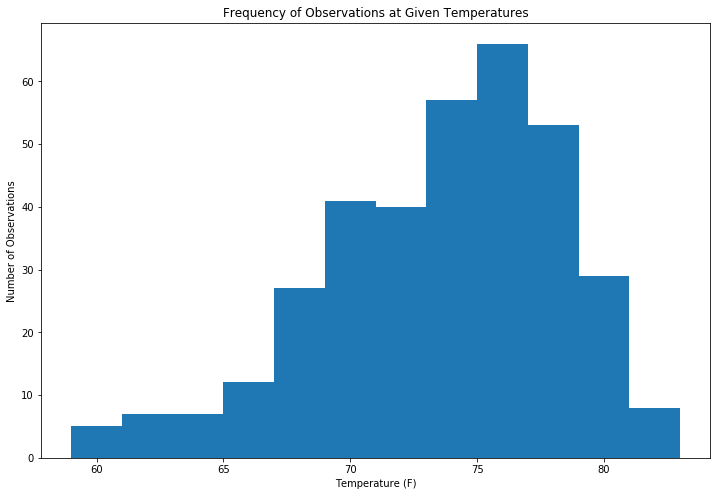

In [62]:
# Plot as histogram
plt.figure(figsize = (12,8))
plt.hist(tobs_df.Temp_Observations, bins = 12)
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Observations')
plt.title('Frequency of Observations at Given Temperatures')
plt.savefig('Output/TempObservations_Histogram.png')
plt.show()

---

### Date Range Temperature Analysis

This is one of the optional sections.  In this section we will:
* use the provided calc_temps function to calulate min, max, and average temperature in a given date range
* accept inputs from the user in order to calculate the temperature information

NOTE: The desired temperature data will be for the dates one year prior to the user's inputs.

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates (minus one year)

# TAKEN FROM STARTER FILE PROVIDED IN THIS WEEK'S GITLAB REPOSITORY

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [63]:
# The following section receives inputs from the user and runs the 'calc_temps' function
print('Please enter dates for your trip (trip must end on or prior to 2018-08-23)')
user_start = input('Start Date (YYYY-mm-dd): ')
user_end = input('End Date (YYYY-mm-dd): ')

# Use try-except in order to protect from user input formatting error (i.e., input needs to be YYYY-mm-dd)
try:
    start_date = dt.datetime.strptime(user_start, '%Y-%m-%d') - dt.timedelta(days = 365)
    start_date_string = str(start_date.date())

    end_date = dt.datetime.strptime(user_end, '%Y-%m-%d') - dt.timedelta(days = 365)
    end_date_string = str(end_date.date())
    
    # Make sure start date is prior to end date
    if start_date_string > end_date_string:
        print('Your start date must be prior to your end date.')
    
    # Make sure data exists in the date range one year prior to user inputs
    elif user_end > '2018-08-23':
        print('Data does not exist for the given date range.')
    
    # Calculate temperature information
    else:
        results = calc_temps(start_date_string, end_date_string)
        TMIN = results[0][0]
        TAVE = results[0][1]
        TMAX = results[0][2]

        print(f'The low temperature a year prior to your date range was {TMIN} degrees Fahrenheit.')
        print(f'The average temperature a year prior to your date range was {TAVE} degrees Fahrenheit.')
        print(f'The high temperature a year prior to your date range was {TMAX} degrees Fahrenheit.')

except:
    print('Your inputs did not match the required format (YYYY-mm-dd)')

Please enter dates for your trip (trip must end on or prior to 2018-08-23)
Start Date (YYYY-mm-dd): 2018-01-01
End Date (YYYY-mm-dd): 2018-01-08
The low temperature a year prior to your date range was 60.0 degrees Fahrenheit.
The average temperature a year prior to your date range was 68.27659574468085 degrees Fahrenheit.
The high temperature a year prior to your date range was 74.0 degrees Fahrenheit.


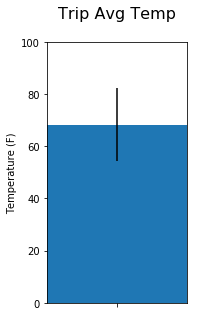

In [64]:
# Plot above information as a bar graph with single bar
plt.figure(figsize = (2.5, 4.8))
plt.bar(0.1, TAVE, yerr = TMAX - TMIN)
plt.xlim(0, 0.2)
plt.ylim(0, 100)
plt.xticks([0.1], labels = [])
plt.ylabel('Temperature (F)')
plt.title('Trip Avg Temp\n', fontsize = 16)
plt.savefig('Output/TripAvgTemp.png')
plt.show()